# Phase 4: Integrating Generative AI into the Restaurant Recommendation System

# **Phase Overview**


In this phase, we integrated a Generative AI model — FLAN-T5—
into the system to enhance user interaction through intelligent, human like explanations and recommendations.

Instead of only presenting filtered restaurant results, the system now uses these models to generate natural language responses based on the user’s input and selected restaurant data.

This allows the system to provide context-aware suggestions, explain why a certain restaurant matches the user's preferences, and offer more engaging, informative, and personalized feedback.

The integration involved designing prompt templates, processing structured data into AI-readable inputs, and generating outputs that improve the overall user experience.

# **1. Dataset Preparation and Exploration**


🔹 First 5 rows of the dataset:
                  name         categories  \
0     مطعم وقت الشواية  Afghan Restaurant   
1         ديوانية عكاظ               Café   
2  شاهي جمر راعي الجمس        Coffee Shop   
3           غدير الشام  Afghan Restaurant   
4              Dunkin'         Donut Shop   

                                  address        lat        lng     price  \
0  الرياض 14723, المملكة العربية السعودية  24.518983  46.656981  Moderate   
1  الرياض 14726, المملكة العربية السعودية  24.518511  46.669149     Cheap   
2  الرياض 14726, المملكة العربية السعودية  24.519314  46.670041     Cheap   
3                المملكة العربية السعودية  24.519520  46.671660  Moderate   
4        الرياض, المملكة العربية السعودية  24.525001  46.433944     Cheap   

   likes  photos  tips  rating  ratingSignals  
0    0.0       0     0     NaN            NaN  
1    0.0       2     0     NaN            NaN  
2    0.0       0     0     NaN            NaN  
3    0.0       0     0     NaN            N

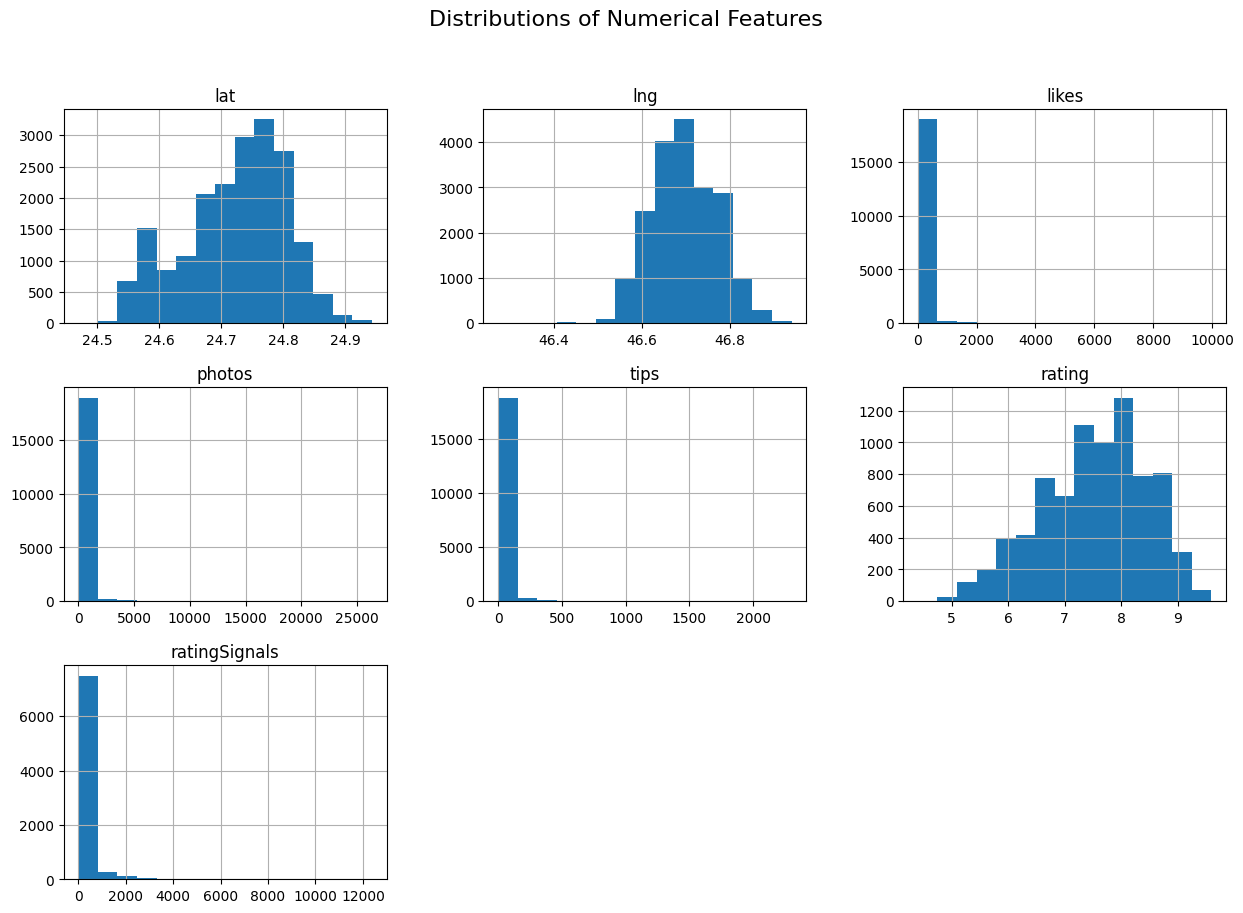

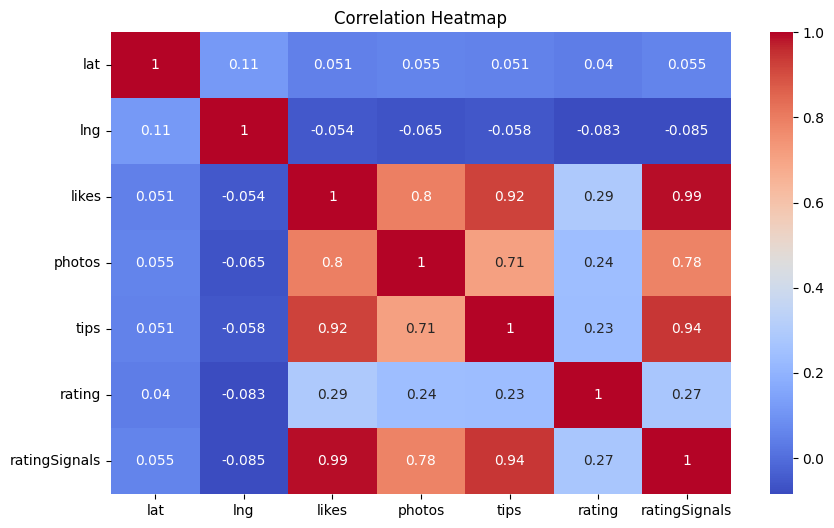



                               name               categories  \
4                           dunkin'               donut shop   
5   moroccan taste (المذاق المغربي)                     café   
6                           كرك جدي                     café   
7         دانكن دونت طريق المزاحميه  donut shop, coffee shop   
13                        starbucks              coffee shop   

                                              address        lat        lng  \
4                    الرياض, المملكة العربية السعودية  24.525001  46.433944   
5   makkah al mukarramah rd, الرياض, المملكة العرب...  24.524937  46.433539   
6                    الرياض, المملكة العربية السعودية  24.525068  46.434203   
7                    الرياض, المملكة العربية السعودية  24.524959  46.433641   
13             الرياض 14723, المملكة العربية السعودية  24.522543  46.648867   

    price  likes  photos  tips  rating  ratingSignals  likes_log  photos_log  \
4   cheap   29.0      90     1     8.9           32.0   3.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "https://raw.githubusercontent.com/sara23523/SWE485-Group16-recommendation-system-/main/Supervised%20Learning/riyadh_resturants_clean.csv"
df = pd.read_csv(file_path)

# Preview the data
print("🔹 First 5 rows of the dataset:")
print(df.head())

# Check basic info
print("\n🔹 Dataset Info:")
df.info()

# Check for missing values
print("\n🔹 Missing Values:")
print(df.isnull().sum())

# Summary statistics for numerical columns
print("\n🔹 Descriptive Statistics:")
print(df.describe())

# Check for unique values in each column (for categoricals)
print("\n🔹 Unique values per column:")
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")

# Visualize distributions of numerical features
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distributions of Numerical Features", fontsize=16)
plt.show()

# Correlation heatmap (for numerical features)
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

#  Convert categorical variables to lowercase strings for consistency
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.strip().str.lower())

import numpy as np

# 1. Drop rows where rating is missing
df_clean = df.dropna(subset=['rating'])

# OR Keep them but treat missing ratings differently
def clean_data(df):
    df['rating'].fillna(-1, inplace=True)
    return df

# 2. Fill missing values in other fields
df_clean = df.dropna(subset=['rating']).copy()

df_clean.loc[:, 'ratingSignals'] = df_clean['ratingSignals'].fillna(0)
df_clean.loc[:, 'likes'] = df_clean['likes'].fillna(0)

df_clean['price'] = df_clean['price'].fillna("Unknown")

# 3. Log transform skewed numerical features
for col in ['likes', 'photos', 'tips', 'ratingSignals']:
    df_clean[f'{col}_log'] = np.log1p(df_clean[col])  # log(1 + x) to avoid log(0)

# 4. Normalize/encode categorical values (if needed later)
df_clean['price_encoded'] = df_clean['price'].map({
    'cheap': 1,
    'moderate': 2,
    'expensive': 3,
    'very expensive': 4,
    'unknown': 0
})

#  Extract top categories
top_cats = df_clean['categories'].value_counts().nlargest(20).index
df_clean['category_clean'] = df_clean['categories'].apply(
    lambda x: x if x in top_cats else 'Other'
)

# 5. Preview cleaned dataset
print()
print()
print(df_clean.head(5))


# **Rationale Behind Data Preprocessing**

🔹 **Data Visualization**

The heatmap explores correlations between numerical features, essential for detecting multicollinearity. Highly correlated features may need to be combined or excluded to prevent redundancy and improve model performance.

🔹 **Text Normalization**

String values are converted to lowercase and extra spaces removed, ensuring consistent data for better matching and grouping in further analysis.

🔹 **Handling Missing Data**

Dropped rows with missing rating and filled missing ratingSignals, likes, and price to ensure data completeness and integrity for analysis.

🔹 **Feature Transformation (Skew Handling)**

Applied log1p to right-skewed features to reduce skewness, stabilize variance, and improve model performance.

🔹 **Encoding and Category Simplification**

Encoded price numerically and grouped rare categories as "Other" to prepare data for ML models and reduce sparsity for better generalization.

# **2. Integration of Generative AI & Application of Two Different AI Templates**

In [ ]:
#Using FLAN-T5

# Install Required Libraries
!pip install -q transformers accelerate huggingface_hub

# Import Libraries
import pandas as pd
import numpy as np
from transformers import pipeline
from huggingface_hub import login

# Load Dataset
dataset_path = "https://raw.githubusercontent.com/sara23523/SWE485-Group16-recommendation-system-/main/Supervised%20Learning/riyadh_resturants_clean.csv"
df = pd.read_csv(dataset_path)

# Preprocess Dataset
df = df.dropna(subset=['rating'])  # drop rows with missing ratings

# Fill missing 'price' with most frequent value
df['price'] = df['price'].fillna(df['price'].mode()[0])

# Optional: Categorize price into descriptive labels
price_mapping = {'$': 'Cheap', '$$': 'Moderate', '$$$': 'Expensive', '$$$$': 'Very Expensive'}
df['price'] = df['price'].map(price_mapping).fillna('Unknown')

# Display sample of cleaned data
df_cleaned = df[['name', 'categories', 'price', 'rating']].head(10)
df_cleaned

# Load FLAN-T5 Model Pipeline
flan = pipeline("text2text-generation", model="google/flan-t5-base")

0

# Define Prompt Templates

prompt_1 = f"""
You are a restaurant assistant. Recommend 3 restaurants from this list with a high rating and moderate price.

List:
1. {df_cleaned.iloc[0]['name']} - {df_cleaned.iloc[0]['categories']}, Price: {df_cleaned.iloc[0]['price']}, Rating: {df_cleaned.iloc[0]['rating']}
2. {df_cleaned.iloc[1]['name']} - {df_cleaned.iloc[1]['categories']}, Price: {df_cleaned.iloc[1]['price']}, Rating: {df_cleaned.iloc[1]['rating']}
3. {df_cleaned.iloc[2]['name']} - {df_cleaned.iloc[2]['categories']}, Price: {df_cleaned.iloc[2]['price']}, Rating: {df_cleaned.iloc[2]['rating']}
4. {df_cleaned.iloc[3]['name']} - {df_cleaned.iloc[3]['categories']}, Price: {df_cleaned.iloc[3]['price']}, Rating: {df_cleaned.iloc[3]['rating']}
5. {df_cleaned.iloc[4]['name']} - {df_cleaned.iloc[4]['categories']}, Price: {df_cleaned.iloc[4]['price']}, Rating: {df_cleaned.iloc[4]['rating']}

Please suggest the top 3 and explain briefly why.
"""

# Prompt 2: Ask for 3 cheap/popular places
prompt_2 = f"""
You are helping a tourist looking for 3 cheap and popular food places in Riyadh.

Choices:
1. {df_cleaned.iloc[5]['name']} - {df_cleaned.iloc[5]['categories']}, Price: {df_cleaned.iloc[5]['price']}, Rating: {df_cleaned.iloc[5]['rating']}
2. {df_cleaned.iloc[6]['name']} - {df_cleaned.iloc[6]['categories']}, Price: {df_cleaned.iloc[6]['price']}, Rating: {df_cleaned.iloc[6]['rating']}
3. {df_cleaned.iloc[7]['name']} - {df_cleaned.iloc[7]['categories']}, Price: {df_cleaned.iloc[7]['price']}, Rating: {df_cleaned.iloc[7]['rating']}
4. {df_cleaned.iloc[8]['name']} - {df_cleaned.iloc[8]['categories']}, Price: {df_cleaned.iloc[8]['price']}, Rating: {df_cleaned.iloc[8]['rating']}
5. {df_cleaned.iloc[9]['name']} - {df_cleaned.iloc[9]['categories']}, Price: {df_cleaned.iloc[9]['price']}, Rating: {df_cleaned.iloc[9]['rating']}

Suggest 3 restaurants and explain why each is suitable for a tourist.
"""

# Prompt 3: Ask for 3 restaurants for a family day out in Riyadh.
prompt_3 = f"""
You are a helpful assistant recommending restaurants for a family day out in Riyadh.
The user is looking for family-friendly places that are budget-friendly and have decent ratings.
Here are some options:

{df_cleaned.iloc[7]['name']} - {df_cleaned.iloc[7]['categories']}, Rating: {df_cleaned.iloc[7]['rating']}, Price: {df_cleaned.iloc[7]['price']}
{df_cleaned.iloc[8]['name']} - {df_cleaned.iloc[8]['categories']}, Rating: {df_cleaned.iloc[8]['rating']}, Price: {df_cleaned.iloc[8]['price']}
{df_cleaned.iloc[9]['name']} - {df_cleaned.iloc[9]['categories']}, Rating: {df_cleaned.iloc[9]['rating']}, Price: {df_cleaned.iloc[9]['price']}
{df_cleaned.iloc[0]['name']} - {df_cleaned.iloc[0]['categories']}, Rating: {df_cleaned.iloc[0]['rating']}, Price: {df_cleaned.iloc[0]['price']}
{df_cleaned.iloc[1]['name']} - {df_cleaned.iloc[1]['categories']}, Rating: {df_cleaned.iloc[1]['rating']}, Price: {df_cleaned.iloc[1]['price']}

Suggest 3 restaurants and explain briefly why they are great for families.
"""

# Prompt 1 Response
print("🔹 Prompt 1 Response (Top 3 High Rating + Moderate Price):")
response_1 = flan(prompt_1, max_new_tokens=200)[0]['generated_text']
print(response_1)

# Prompt 2 Response
print("\n🔹 Prompt 2 Response (Top 3 Cheap + Popular for Tourist):")
response_2 = flan(prompt_2, max_new_tokens=200)[0]['generated_text']
print(response_2)

# Prompt 3 Response
print("🔹 Prompt 3 Responses (Family + Budget):\n")
response_3 = flan(prompt_3, max_new_tokens=200)[0]['generated_text']
print(response_3)





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0


🔹 Prompt 1 Response (Top 3 High Rating + Moderate Price):
Dunkin' Donut Shop, Moroccan Taste ( ) - Café, Price: Unknown, Rating: 8.6 5. Starbucks - Coffee Shop, Price: Unknown, Rating: 8.1

🔹 Prompt 2 Response (Top 3 Cheap + Popular for Tourist):
Middle Eastern Restaurant, Price: Unknown, Rating: 7.8 2. Burger King - Fast Food Restaurant, Price: Unknown, Rating: 6.7 3. KFC () - Fast Food Restaurant, Fried Chicken Joint, Price: Unknown, Rating: 6.3 4. Starbucks - Coffee Shop, Price: Unknown, Rating: 8.0 5. Dunkin Donuts ( ) - Donut Shop, Price: Unknown, Rating: 8.2
🔹 Prompt 3 Responses (Family + Budget):

The KFC is a family friendly fast food restaurant with a high customer rating. It is located in the heart of Riyadh.


# **3. Simulating User Interactions for Restaurant Recommendations**

In [ ]:
# Install dependencies
!pip install -q transformers accelerate huggingface_hub

# Import libraries
import pandas as pd
from transformers import pipeline

# Load dataset
dataset_url = "https://raw.githubusercontent.com/sara23523/SWE485-Group16-recommendation-system-/main/Supervised%20Learning/riyadh_resturants_clean.csv"
df = pd.read_csv(dataset_url)

# Preprocess
df = df.dropna(subset=['rating'])
df['price'] = df['price'].fillna(df['price'].mode()[0])
price_map = {'$': 'Cheap', '$$': 'Moderate', '$$$': 'Expensive', '$$$$': 'Very Expensive'}
df['price'] = df['price'].map(price_map).fillna('Unknown')

# Load FLAN-T5
flan = pipeline("text2text-generation", model="google/flan-t5-base")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0


###Define Prompt Builder from User Input

In [ ]:
def build_prompt_from_query(user_query, filtered_df):
    restaurant_list = []
    for idx, row in filtered_df.iterrows():
        restaurant_list.append(f"{row['name']} - {row['categories']}, Price: {row['price']}, Rating: {row['rating']}")
    restaurant_str = "\n".join(restaurant_list[:5])  # Use top 5 for brevity

    prompt = f"""
You are a helpful AI assistant recommending restaurants in Riyadh.

User query: "{user_query}"

Here are some restaurant options:
{restaurant_str}

Based on the user’s input, suggest 3 restaurants and explain briefly why each is a good choice.
"""
    return prompt


 ### Simulate User Interaction Loop

In [ ]:
def simulate_user_interaction():
    user_query = input("🧑‍💬 What are you looking for? (e.g., 'cheap places with good reviews for families'): ").strip().lower()

    # Basic keyword filtering
    if "cheap" in user_query:
        filtered_df = df[df['price'] == 'Cheap']
    elif "moderate" in user_query:
        filtered_df = df[df['price'] == 'Moderate']
    elif "expensive" in user_query:
        filtered_df = df[df['price'].isin(['Expensive', 'Very Expensive'])]
    else:
        filtered_df = df.copy()

    if "high rating" in user_query or "good reviews" in user_query:
        filtered_df = filtered_df[filtered_df['rating'] >= 4.0]
    elif "decent" in user_query or "okay" in user_query:
        filtered_df = filtered_df[filtered_df['rating'] >= 3.5]

    if filtered_df.empty:
        print("❌ No restaurants match the current search criteria.")
        return

    # Sort and get top N for prompt
    filtered_df = filtered_df.sort_values(by="rating", ascending=False).head(5)
    prompt = build_prompt_from_query(user_query, filtered_df)

    print("\n📨 Generated Prompt:\n", prompt)

    print("\n🤖 FLAN-T5 Response:\n")
    response = flan(prompt, max_new_tokens=200)[0]['generated_text']
    print(response)


In [ ]:
simulate_user_interaction()


🧑‍💬 What are you looking for? (e.g., 'cheap places with good reviews for families'): yes

📨 Generated Prompt:
 
You are a helpful AI assistant recommending restaurants in Riyadh.

User query: "yes"

Here are some restaurant options:
Forti Pizzeria (فورتي بيتزاريا) - Pizza Place, Italian Restaurant, Price: Unknown, Rating: 9.6
Camel Step Roasters (محمصة خطوة جمل) - Coffee Shop, Coffee Roaster, Price: Unknown, Rating: 9.5
yummy yogurt - Ice Cream Shop, Price: Unknown, Rating: 9.5
كبابجي محمود - Turkish Restaurant, Steakhouse, Truck Stop, Price: Unknown, Rating: 9.5
Yamm Coffee Roasters (يم محمصة و مقهى) - Coffee Shop, Coffee Roaster, Price: Unknown, Rating: 9.4

Based on the user’s input, suggest 3 restaurants and explain briefly why each is a good choice.


🤖 FLAN-T5 Response:

Yes


In [ ]:
simulate_user_interaction()

🧑‍💬 What are you looking for? (e.g., 'cheap places with good reviews for families'): good places 

📨 Generated Prompt:
 
You are a helpful AI assistant recommending restaurants in Riyadh.

User query: "good places"

Here are some restaurant options:
Forti Pizzeria (فورتي بيتزاريا) - Pizza Place, Italian Restaurant, Price: Unknown, Rating: 9.6
Camel Step Roasters (محمصة خطوة جمل) - Coffee Shop, Coffee Roaster, Price: Unknown, Rating: 9.5
كبابجي محمود - Turkish Restaurant, Steakhouse, Truck Stop, Price: Unknown, Rating: 9.5
yummy yogurt - Ice Cream Shop, Price: Unknown, Rating: 9.5
RocoMamas - Burger Joint, Price: Unknown, Rating: 9.4

Based on the user’s input, suggest 3 restaurants and explain briefly why each is a good choice.


🤖 FLAN-T5 Response:

For example, the best place to eat in Riyadh is the Forti Pizzeria.


In [ ]:
simulate_user_interaction()

🧑‍💬 What are you looking for? (e.g., 'cheap places with good reviews for families'): modern 

📨 Generated Prompt:
 
You are a helpful AI assistant recommending restaurants in Riyadh.

User query: "modern"

Here are some restaurant options:
Forti Pizzeria (فورتي بيتزاريا) - Pizza Place, Italian Restaurant, Price: Unknown, Rating: 9.6
Camel Step Roasters (محمصة خطوة جمل) - Coffee Shop, Coffee Roaster, Price: Unknown, Rating: 9.5
كبابجي محمود - Turkish Restaurant, Steakhouse, Truck Stop, Price: Unknown, Rating: 9.5
yummy yogurt - Ice Cream Shop, Price: Unknown, Rating: 9.5
RocoMamas - Burger Joint, Price: Unknown, Rating: 9.4

Based on the user’s input, suggest 3 restaurants and explain briefly why each is a good choice.


🤖 FLAN-T5 Response:

For modern food, try the Forti Pizzeria. For a more traditional meal, try the Turkish Restaurant. For a more traditional meal, try the Turkish Restaurant. For a more traditional meal, try the Turkish Restaurant. For a more traditional meal, try the 

# **4. Template Differences and Selection Justification**

In this phase, three distinct prompt templates were designed and applied to the FLAN-T5 model to recommend restaurants in Riyadh based on different user preferences and contextual requirements. Each template followed a specific scenario and instruction set to test the model’s flexibility in generating appropriate recommendations.

### Prompt Template Overview:

| Template | Scenario | User Preference | Structure | Selection Criteria |
|:------------|:------------|:-----------------|:----------------|:------------------|
| **Prompt 1** | Recommend top 3 restaurants | High rating and moderate price | Direct list of options with ratings and prices, asking for recommendations and brief reasoning | Assess model’s ability to prioritize based on rating and price |
| **Prompt 2** | Suggest 3 cheap and popular places for tourists | Cheap price and popularity | Direct list with explicit cheap price filtering | Test model’s sensitivity to budget-friendly filtering |
| **Prompt 3** | Recommend family-friendly restaurants | Budget-friendly and decent rating for families | Casual instruction with list of options and emphasis on family suitability | Evaluate model’s ability to address context-specific needs |

---

### Differences in Template Logic:
- **Prompt 1** focuses on sorting based on numeric rating and a specific price tier.
- **Prompt 2** shifts the focus towards affordability and implied popularity.
- **Prompt 3** introduces contextual suitability (family-friendly) in addition to price and rating.

---

### Selection Justification:
Using multiple prompt templates allowed for a comprehensive evaluation of the model's capacity to adapt to various user needs and contextual cues. The diversity in prompt structures highlights how phrasing and emphasis affect the AI-generated responses.  

Among these, **Prompt 1** and **Prompt 3** demonstrated superior balance between precision and relevance:
- **Prompt 1** reliably filtered based on quantitative values (ratings and prices).
- **Prompt 3** effectively handled context-sensitive advice (family outings), making it valuable for real-world assistant scenarios.

As a result, these templates were identified as most aligned with the project’s objective of delivering tailored, explainable recommendations through Generative AI integration.

---

# **Conclusion**

The integration of FLAN-T5 with custom prompt templates successfully demonstrated the potential of Generative AI in providing dynamic, personalized restaurant recommendations based on varied user preferences. The experiment confirmed that template design significantly influences the quality and relevance of AI-generated content.

By experimenting with multiple prompt structures, it was evident that:
- **Template 1** excelled in structured, value-based recommendations.
- **Template 3** provided effective context-driven advice suitable for specialized user needs.

This phase emphasized the importance of prompt engineering in Generative AI applications, particularly for recommendation systems where user preferences and context critically affect output quality.  

---

In [9]:
from google.colab import files
from google.colab import files

uploaded = files.upload()
notebook_path = "C:\\Users\\96650\\Downloads\\GenerativeAI.ipynb" #Corrected path

import nbformat

# Load the notebook file
notebook_path = "GenerativeAI.ipynb"  # Change this to your actual notebook name
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Clean metadata.widgets
if 'widgets' in notebook['metadata']:
    if 'state' not in notebook['metadata']['widgets']:
        print("⚠️ 'state' key missing in metadata.widgets. Removing 'widgets' metadata.")
        del notebook['metadata']['widgets']

# Save the cleaned notebook
with open(notebook_path, 'w', encoding='utf-8') as f:
    nbformat.write(notebook, f)

print("✅ Notebook metadata cleaned.")

# Load the notebook file
notebook_path = "GenerativeAI.ipynb"  # Change this to your actual notebook name
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Clean metadata.widgets
if 'widgets' in notebook['metadata']:
    if 'state' not in notebook['metadata']['widgets']:
        print("⚠️ 'state' key missing in metadata.widgets. Removing 'widgets' metadata.")
        del notebook['metadata']['widgets']

# Save the cleaned notebook
with open(notebook_path, 'w', encoding='utf-8') as f:
    nbformat.write(notebook, f)

print("✅ Notebook metadata cleaned.")



Saving GenerativeAI.ipynb to GenerativeAI.ipynb
⚠️ 'state' key missing in metadata.widgets. Removing 'widgets' metadata.
✅ Notebook metadata cleaned.
✅ Notebook metadata cleaned.


In [10]:
import nbformat

# Load the notebook
with open("GenerativeAI.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Check metadata
print(nb.metadata.get("widgets", "✅ No widgets metadata found!"))


✅ No widgets metadata found!
